In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import isoparse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set universal font sizes using rcParams
plt.rcParams['axes.labelsize'] = 17  # For x and y labels
plt.rcParams['xtick.labelsize'] = 15  # For x-ticks
plt.rcParams['ytick.labelsize'] = 15  # For y-ticks
plt.rcParams['legend.fontsize'] = 15  # For legend
plt.rcParams['axes.titlesize'] = 17

In [2]:
def construct_formatted_df(input_csv):
    formatted_df = pd.read_csv(input_csv, index_col=0)
    return formatted_df

In [3]:
def calculate_failure_bursts(formatted_df):
    burst_df = pd.DataFrame(columns=['Timestamp start', 'Timestamp end', 'Burst dur', 'Failure count', 'Num racks affected', \
                                     'Individual or burst', 'Rack list', 'Enc list', 'Slot list'])
    
    ts = formatted_df.loc[0, "Timestamp"]
    time_start = ts
    time_end = ts
    if_burst = 'I'
    failure_count = 1
    racks = []
    racks.append(formatted_df.loc[0, "Rack id"])
    encs = []
    encs.append(formatted_df.loc[0, "Unique enclosure"])
    slots = []
    slots.append(formatted_df.loc[0, "Slot"])
    i = 1
    j = 0
    failure_count_sum=0
    while i < len(formatted_df.index):
        ts_next = formatted_df.loc[i, "Timestamp"]
        time_diff = isoparse(ts_next).timestamp() - isoparse(ts).timestamp()
        

        if(time_diff < 900):
            
            if_burst = 'B'
            failure_count = failure_count+1
            time_end = ts_next
            rack_id = formatted_df.loc[i, "Rack id"]
            enc = formatted_df.loc[i, "Unique enclosure"]
            slot = formatted_df.loc[i, "Slot"]
            if rack_id not in racks:
                racks.append(rack_id)
            if enc not in encs:
                encs.append(enc)
            if slot not in slots:
                slots.append(slot)
            ts = ts_next
            time_end=ts
        
        else:
            burst_df.loc[j, "Timestamp start"] = time_start
            burst_df.loc[j, "Timestamp end"] = time_end
            burst_df.loc[j, "Burst dur"] = isoparse(time_end).timestamp()-isoparse(time_start).timestamp()
            burst_df.loc[j, "Failure count"] = failure_count
            failure_count_sum += failure_count
            burst_df.loc[j, "Num racks affected"] = len(set(racks))
            burst_df.loc[j, "Individual or burst"] = if_burst
            burst_df.loc[j, "Rack list"] = racks
            burst_df.loc[j, "Enc list"] = encs
            burst_df.loc[j, "Slot list"] = slots
        
            ts = formatted_df.loc[i, "Timestamp"]
            time_start = ts
            time_end = ts
            if_burst = 'I'
            failure_count = 1
            racks = []
            racks.append(formatted_df.loc[i, "Rack id"])
            encs = []
            encs.append(formatted_df.loc[i, "Unique enclosure"])
            slots = []
            slots.append(formatted_df.loc[i, "Slot"])
            j = j+1
        i = i+1
    
  
    burst_df.loc[j, "Timestamp start"] = time_start
    burst_df.loc[j, "Timestamp end"] = time_end
    burst_df.loc[j, "Burst dur"] = isoparse(time_end).timestamp()-isoparse(time_start).timestamp()
    burst_df.loc[j, "Failure count"] = failure_count
    failure_count_sum += failure_count
    burst_df.loc[j, "Num racks affected"] = len(set(racks))
    burst_df.loc[j, "Individual or burst"] = if_burst
    burst_df.loc[j, "Rack list"] = racks
    burst_df.loc[j, "Enc list"] = encs
    burst_df.loc[j, "Slot list"] = slots
    
    return burst_df
            

In [4]:
def print_burst_chara_stats(formatted_df, burst_df, store_name):
    individual_failures = burst_df.loc[(burst_df['Failure count'] == 1), 'Failure count'].sum()
    total_failures = len(formatted_df)
    print("failures in bursts %: ", (total_failures-individual_failures)/total_failures)
    print("min Bdur: ", burst_df.loc[(burst_df['Failure count'] != 1), 'Burst dur'].min())
    print("median Bdur: ", burst_df.loc[(burst_df['Failure count'] != 1), 'Burst dur'].median())
    print("max Bdur: ", burst_df.loc[(burst_df['Failure count'] != 1), 'Burst dur'].max())
    
    print("min Bsize: ", burst_df.loc[(burst_df['Failure count'] != 1), 'Failure count'].min())
    print("median Bsize: ", burst_df.loc[(burst_df['Failure count'] != 1), 'Failure count'].median())
    print("max Bsize: ", burst_df.loc[(burst_df['Failure count'] != 1), 'Failure count'].max())
    
    total_bursts = burst_df.loc[(burst_df['Failure count'] != 1)].shape[0]

    if store_name == "Alpine":
        bursts_under_10_mins = burst_df.loc[(burst_df['Failure count'] != 1) & (burst_df['Burst dur'] < 600)].shape[0]
        print("under 10 minutes %:- ", bursts_under_10_mins/total_bursts)
        two_failure_bursts = burst_df.loc[(burst_df['Failure count'] == 2)].shape[0]
        print("two failure bursts %:- ", two_failure_bursts/total_bursts)
        print("dur of largest burst:- ", burst_df.loc[(burst_df['Failure count'] == 18), 'Burst dur'].tolist())
    
    elif store_name == "Campaign":
        print("dur of largest burst:- ", burst_df.loc[(burst_df['Failure count'] == 80), 'Burst dur'].tolist())
        print("Time start of largest burst:- ", burst_df.loc[(burst_df['Failure count'] == 80), 'Timestamp start'].tolist())
        print("Time end of largest burst:- ", burst_df.loc[(burst_df['Failure count'] == 80), 'Timestamp end'].tolist())
        bursts_under_5_mins = burst_df.loc[(burst_df['Failure count'] != 1) & (burst_df['Burst dur'] < 300)].shape[0]
        print("under 5 minutes %:- ", bursts_under_5_mins/total_bursts)

In [5]:
def generate_burst_count_df_for_bdur_bsize_pair(burst_df):
    #create (bdur-failures) tuple and a df out of it with burst occurances
    bdur_failures_tuple = list(zip(burst_df["Burst dur"], burst_df["Failure count"]))
    



    bdur_failures_tuple_dict = {}
    count = 0
    for i in range(len(bdur_failures_tuple)):
        if(bdur_failures_tuple[i]) not in bdur_failures_tuple_dict:
            bdur_failures_tuple_dict[bdur_failures_tuple[i]] = 1
        else:
            bdur_failures_tuple_dict[bdur_failures_tuple[i]] = bdur_failures_tuple_dict[bdur_failures_tuple[i]]+1




    i = 0
    burst_count_df = pd.DataFrame(columns=['Burst dur', 'Burst size', 'Burst count'])
    for elem in bdur_failures_tuple_dict:
        burst_count_df.loc[i, 'Burst dur'] = elem[0]
        burst_count_df.loc[i, 'Burst size'] = elem[1]
        burst_count_df.loc[i, 'Burst count'] = bdur_failures_tuple_dict[elem]
        i = i+1

    
    burst_count_df = burst_count_df.astype({"Burst count":'int'})
    
    i = 0

    while i<(len(burst_count_df.index)):
        freq = burst_count_df.loc[i, 'Burst count']
        if freq > 0 and freq <= 10:
            burst_count_df.loc[i, 'bubble_size'] = freq*15
        elif freq > 10 and freq <=100:
            burst_count_df.loc[i, 'bubble_size'] = freq*10
        elif freq > 100 and freq <= 1000:
            burst_count_df.loc[i, 'bubble_size'] = freq*5
        else:
            burst_count_df.loc[i, 'bubble_size'] = freq
        i = i+1


    
    return burst_count_df

In [6]:
def print_bcount_for_bdur_bsize_pair_stats(burst_count_df, store_name):
    
    print("min Bcount: ", burst_count_df.loc[(burst_count_df['Burst size'] != 1), 'Burst count'].min())
    print("median Bcount: ", burst_count_df.loc[(burst_count_df['Burst size'] != 1), 'Burst count'].median())
    print("max Bcount: ", burst_count_df.loc[(burst_count_df['Burst size'] != 1), 'Burst count'].max())
    
    if store_name == "Alpine":
        print("bcount 30, bdur:- ", burst_count_df.loc[(burst_count_df['Burst count'] == 30), 'Burst dur'].tolist())
        print("bcount 30, bsize:- ", burst_count_df.loc[(burst_count_df['Burst count'] == 30), 'Burst size'].tolist())
    elif store_name == "Campaign":
        print("bcount 40, bdur:- ", burst_count_df.loc[(burst_count_df['Burst count'] == 40), 'Burst dur'].tolist())
        print("bcount 40, bsize:- ", burst_count_df.loc[(burst_count_df['Burst count'] == 40), 'Burst size'].tolist())

In [7]:
def generate_burst_count_df_for_racks_drives_pair(burst_df):
    #create (racks-failures) tuple and a df out of it with burst occurances
    racks_failures_tuple = list(zip(burst_df["Num racks affected"], burst_df["Failure count"]))
    



    racks_failures_tuple_dict = {}
    count = 0
    for i in range(len(racks_failures_tuple)):
        if(racks_failures_tuple[i]) not in racks_failures_tuple_dict:
            racks_failures_tuple_dict[racks_failures_tuple[i]] = 1
        else:
            racks_failures_tuple_dict[racks_failures_tuple[i]] = racks_failures_tuple_dict[racks_failures_tuple[i]]+1




    i = 0
    burst_count_df = pd.DataFrame(columns=['Num racks affected', 'Num drives affected', 'Burst count'])
    for elem in racks_failures_tuple_dict:
        burst_count_df.loc[i, 'Num racks affected'] = elem[0]
        burst_count_df.loc[i, 'Num drives affected'] = elem[1]
        burst_count_df.loc[i, 'Burst count'] = racks_failures_tuple_dict[elem]
        i = i+1

    
    burst_count_df = burst_count_df.astype({"Burst count":'int'})
    
    i = 0

    while i<(len(burst_count_df.index)):
        freq = burst_count_df.loc[i, 'Burst count']
        if freq > 0 and freq <= 10:
            burst_count_df.loc[i, 'bubble_size'] = freq*15
        elif freq > 10 and freq <=100:
            burst_count_df.loc[i, 'bubble_size'] = freq*10
        elif freq > 100 and freq <= 1000:
            burst_count_df.loc[i, 'bubble_size'] = freq*5
        else:
            burst_count_df.loc[i, 'bubble_size'] = freq
        i = i+1


    
    return burst_count_df

In [8]:
def generate_spatial_burst_corr_plots(alpine_burst_count_df, camp_burst_count_df):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    
    axs[0].scatter(alpine_burst_count_df['Num racks affected'], alpine_burst_count_df['Num drives affected'], 
                          s=alpine_burst_count_df['bubble_size'],  # Bubble size scaled for better visibility
                          alpha=0.6, edgecolors="red", linewidth=0.5, color='coral')
    axs[0].set_xscale('log', base=10)
    axs[0].set_yscale('log', base=10)
    alp_ticks = [1, 2, 5, 10, 20, 50]
    axs[0].set_xticks(alp_ticks, labels=alp_ticks)
    axs[0].set_yticks(alp_ticks, labels=alp_ticks)
    axs[0].set_xlabel('# Racks Affected')
    axs[0].set_ylabel('# Drives failed')
    axs[0].set_title("(a) Alpine")
    axs[0].grid(True, linestyle=':', alpha=0.8)
    axs[0].set_xlim([0, 50])
    axs[0].set_ylim([0, 50])


    axs[1].scatter(camp_burst_count_df['Num racks affected'], camp_burst_count_df['Num drives affected'], 
                          s=camp_burst_count_df['bubble_size'],  # Bubble size scaled for better visibility
                          alpha=0.6, edgecolors="green", linewidth=0.5, color='yellowgreen')
    axs[1].set_xscale('log', base=10)
    axs[1].set_yscale('log', base=10)
    camp_ticks = [1, 2, 5, 10, 20, 50, 100]
    axs[1].set_xticks(camp_ticks, labels=camp_ticks)
    axs[1].set_yticks(camp_ticks, labels=camp_ticks)
    axs[1].set_xlabel('# Racks Affected')
    axs[1].set_title("(b) Campaign")
    axs[1].grid(True, linestyle=':', alpha=0.8)
    axs[1].set_xlim([0, 100])
    axs[1].set_ylim([0, 100])


    for size, label in zip([15, 150, 1000, 3000], ['1', '10', '100', '1000']):
        plt.scatter([], [], c='k', alpha=0.6, s=size, label=label)
    plt.legend(
        #title="Burst count", 
        #title_fontsize='13', 
        labelspacing=2, 
        loc='upper left',
        frameon=True,
        edgecolor='k',
        handlelength=3,
        handleheight=2.75,
        bbox_to_anchor=(1.05, 1.04)

    )

    fig.text(0.84, 0.94, 'Burst count', va='center', fontsize=17)

    plt.tight_layout()
    plt.savefig("spatial_burst_corr.pdf", bbox_inches='tight')



    plt.show()

In [9]:
def print_bcount_for_racks_drives_pair_stats(formatted_df, burst_count_df, store_name):
    individual_failures = burst_count_df.loc[(burst_count_df['Num drives affected'] == 1) & (burst_count_df['Num racks affected'] == 1), 'Burst count'].sum()
    total_failures = len(formatted_df)
    print("failures in bursts %: ", (total_failures-individual_failures)/total_failures)
    
    print("sum of bursts: ", burst_count_df.loc[(burst_count_df['Num drives affected'] != 1), 'Burst count'].sum())
    spatial_bursts = (burst_count_df.loc[(burst_count_df['Num racks affected'] == 1), 'Burst count'].sum()) - individual_failures
    print("sum of spatial bursts: ", spatial_bursts)
    print("sum of non spatial bursts: ", burst_count_df.loc[(burst_count_df['Num racks affected'] != 1), 'Burst count'].sum())
    
    print("min Bcount: ", burst_count_df.loc[(burst_count_df['Num drives affected'] != 1), 'Burst count'].min())
    print("median Bcount: ", burst_count_df.loc[(burst_count_df['Num drives affected'] != 1), 'Burst count'].median())
    print("max Bcount: ", burst_count_df.loc[(burst_count_df['Num drives affected'] != 1), 'Burst count'].max())
    
    

In [10]:
def main():
    #construct formatted df
    alpine_formatted_df= construct_formatted_df("../alpine_formatted_data.csv")
    camp_formatted_df = construct_formatted_df("../camp_formatted_data.csv")
    
    #calculate failure bursts
    alpine_burst_df = calculate_failure_bursts(alpine_formatted_df)
    #print(alpine_burst_df)
    camp_burst_df = calculate_failure_bursts(camp_formatted_df)
    #print(camp_burst_df)
    
    #print stats for bursts - Bdur and Bsize
    print("*********** Alpine ***********")
    print_burst_chara_stats(alpine_formatted_df, alpine_burst_df, "Alpine")
    print("*********** Campaign ***********")
    print_burst_chara_stats(camp_formatted_df, camp_burst_df, "Campaign")

    ##################for [Bdur, Bsize] pair#################################################
     
    #generate burst_count_df_for_bdur_bsize_pair
    alpine_burst_count_df_for_bdur_bsize_pair = generate_burst_count_df_for_bdur_bsize_pair(alpine_burst_df)
    #print(alpine_burst_count_df_for_bdur_bsize_pair)
    camp_burst_count_df_for_bdur_bsize_pair = generate_burst_count_df_for_bdur_bsize_pair(camp_burst_df)
    print(camp_burst_count_df_for_bdur_bsize_pair)
    df_sorted = camp_burst_count_df_for_bdur_bsize_pair.sort_values(by='Burst size', ascending=True)
    print(df_sorted)
    
    #printing stats for bcount for bdur bsize pair
    print("*********** Alpine ***********")
    print_bcount_for_bdur_bsize_pair_stats(alpine_burst_count_df_for_bdur_bsize_pair, "Alpine")
    print("*********** Campaign ***********")
    print_bcount_for_bdur_bsize_pair_stats(camp_burst_count_df_for_bdur_bsize_pair, "Campaign")
    
    ##################for [#racks affected, #drives failed] pair#############################
    
    #generate generate_burst_count_df_for_racks_drives_pair   
    alpine_burst_count_df_for_racks_drives_pair = generate_burst_count_df_for_racks_drives_pair(alpine_burst_df)
    print(alpine_burst_count_df_for_racks_drives_pair)
    camp_burst_count_df_for_racks_drives_pair = generate_burst_count_df_for_racks_drives_pair(camp_burst_df)
    print(camp_burst_count_df_for_racks_drives_pair)
    
    #generating burst correlation plots
    generate_spatial_burst_corr_plots(alpine_burst_count_df_for_racks_drives_pair, camp_burst_count_df_for_racks_drives_pair)

    #printing stats for bcount for racks drives pair
    print("*********** Alpine ***********")
    print_bcount_for_racks_drives_pair_stats(alpine_formatted_df, alpine_burst_count_df_for_racks_drives_pair, "Alpine")
    print("*********** Campaign ***********")
    print_bcount_for_racks_drives_pair_stats(camp_formatted_df, camp_burst_count_df_for_racks_drives_pair, "Campaign")
    

*********** Alpine ***********
failures in bursts %:  0.18879447689856613
min Bdur:  0.0
median Bdur:  42.0
max Bdur:  1484.0
min Bsize:  2
median Bsize:  2.0
max Bsize:  18
under 10 minutes %:-  0.9501779359430605
two failure bursts %:-  0.7651245551601423
dur of largest burst:-  [839.0]
*********** Campaign ***********
failures in bursts %:  0.6969042476601872
min Bdur:  0.0
median Bdur:  1.5
max Bdur:  767.0
min Bsize:  2
median Bsize:  3.0
max Bsize:  80
dur of largest burst:-  [150.0]
Time start of largest burst:-  ['2023-03-29T00:01:07']
Time end of largest burst:-  ['2023-03-29T00:03:37']
under 5 minutes %:-  0.9869565217391304
   Burst dur Burst size  Burst count  bubble_size
0        1.0          2           32        320.0
1        0.0          1          421       2105.0
2        0.0          2           40        400.0
3        3.0          4            2         30.0
4        1.0          3           16        160.0
..       ...        ...          ...          ...
82     

/var/folders/lq/zybt6pkn6_g7rx3p4vby1tthfzzsg8/T/ipykernel_67857/4276872080.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim([0, 50])
/var/folders/lq/zybt6pkn6_g7rx3p4vby1tthfzzsg8/T/ipykernel_67857/4276872080.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim([0, 50])
/var/folders/lq/zybt6pkn6_g7rx3p4vby1tthfzzsg8/T/ipykernel_67857/4276872080.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1].set_xlim([0, 100])
/var/folders/lq/zybt6pkn6_g7rx3p4vby1tthfzzsg8/T/ipykernel_67857/4276872080.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim([0, 100])


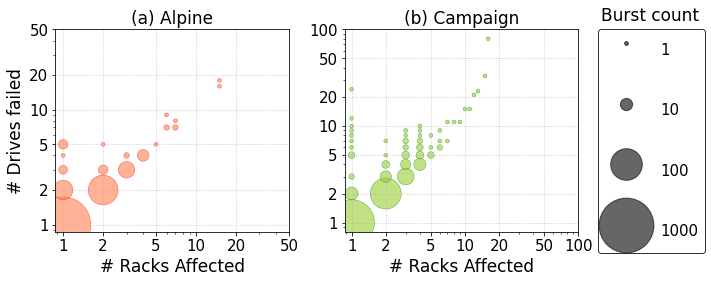

*********** Alpine ***********
failures in bursts %:  0.18879447689856613
sum of bursts:  281
sum of spatial bursts:  50
sum of non spatial bursts:  231
min Bcount:  1
median Bcount:  2.0
max Bcount:  177
*********** Campaign ***********
failures in bursts %:  0.6969042476601872
sum of bursts:  230
sum of spatial bursts:  29
sum of non spatial bursts:  201
min Bcount:  1
median Bcount:  1.0
max Bcount:  96


In [11]:
if __name__ == "__main__":
    main()